# Custom Initial Conditions

This notebook will teach you how to set up a custom gas distribution as initial conditions.

First we create a new directory and change to it.

In [1]:
example_name = "400_custom_initial_conditions"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_name
    os.chdir(example_name)
print("We are in " + os.getcwd())

We are in /home/rometsch/repo/fargocpt/examples/400_custom_initial_conditions


## Make the code

Make sure the code is built by running make again.

If you have not yet compiled the go, please go to the readme and follow the instructions there.
You can also try to run the following cell directly, but it will only output error messages. This might make debugging harder.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

116 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yamlloader = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yamlloader.load(infile)

In [5]:
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 20 # write a snapshot every orbit
config["Nsnapshots"] = 10 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
config["cps"] = 2

with open(configfile, "w") as outfile:
    yamlloader.dump(config, outfile)

## Getting a data skeleton

The next step is to run the code for zero timesteps.
This creates the zeroth and reference snapshots, which we can then modify to our liking.

In [6]:
from fargocpt import run
run(["start", configfile, "-N", "0"], np=2, nt=1, exe="../../bin/fargocpt_exe", detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp7lglhkfk -x OMP_NUM_THREADS=1 ../../bin/fargocpt_exe start setup.yml -N 0
fargo process pid 1390403

[0] MPI rank #  0 runs as process 1390407
[1] MPI rank #  1 runs as process 1390408
[0] MPI rank #  0 OpenMP thread #  0 of  1 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  0 of  1 on cpt-kamino
[0] fargo: This file was compiled on Nov 14 2023, 12:56:40.
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 5.00000e+00 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflecting
[0] BC: Vaz inner = keplerian
[0] BC: Vaz outer = keplerian
[0] DampingTimeFacto

0

In [15]:
import sys
sys.path.append("../../Tools")
from overview import Overview

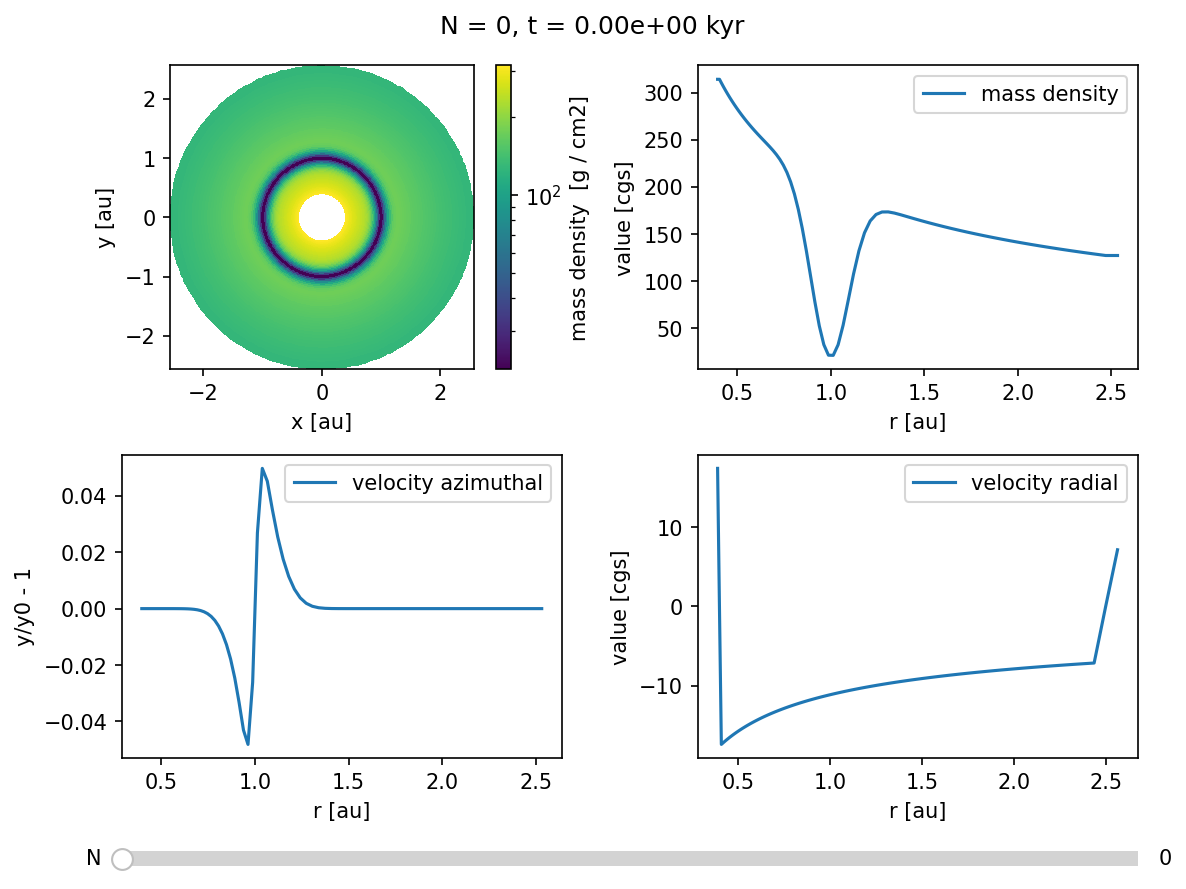

In [16]:
Overview("output/out",
        vars=["2:mass density",
                "1:mass density",
                "1:velocity azimuthal:rel",
                "1:velocity radial"]).create()

## Defining helper functions and classes

In [17]:
import numpy as np
from dataclasses import dataclass
from types import SimpleNamespace
import astropy.units as u
import astropy.constants as const
@dataclass
class FargoCPTField:
    outputdir: str
    snapshotid: str
    name: str

    def __post_init__(self):
        self.filename = f"{self.outputdir}/snapshots/{self.snapshotid}/{self.name}.dat"
        self.grid = get_fargo_grid(self.outputdir)
        if self.name == "vrad":
            self.R, self.Phi = np.meshgrid(self.grid.ri, self.grid.phic, indexing="ij")
        elif self.name == "vtheta":
            self.R, self.Phi = np.meshgrid(self.grid.rc, self.grid.phii[:-1], indexing="ij")
        else:
            self.R, self.Phi = np.meshgrid(self.grid.rc, self.grid.phic, indexing="ij")
        self._load()

    def _load(self):
        self._data = np.fromfile(self.filename, dtype=np.float64)
        self._data = self._data.reshape(self.R.shape[0], self.R.shape[1])

    def save(self, altid=None):
        if altid is not None:
            filename = f"{self.outputdir}/snapshots/{altid}/{self.name}.dat"
        self._data.tofile(self.filename)

    @property
    def array(self):
        return self._data

    @array.setter
    def array(self, data):
        if not self._data.shape == data.shape:
            raise ValueError("Shape of data does not match shape of field")
        self._data = data


def get_fargo_grid(outputdir):

    Nrad, Naz = np.genfromtxt(f"{outputdir}/dimensions.dat", usecols=(4,5), dtype=int, unpack=True)

    ri = np.genfromtxt(f"{outputdir}/used_rad.dat")
    phii = np.linspace(0, 2*np.pi, Naz+1)
    Ri, Phii = np.meshgrid(ri, phii, indexing="ij")
    Xi = Ri*np.cos(Phii)
    Yi = Ri*np.sin(Phii)

    rc = 2/3*(ri[1:]**2/(ri[1:]+ri[:-1]) + ri[:-1]) # approx center in polar coords
    phic = 0.5*(phii[1:]+phii[:-1])
    Rc, Phic = np.meshgrid(rc, phic, indexing="ij")
    Xc = Rc*np.cos(Phic)
    Yc = Rc*np.sin(Phic)

    dphi = phii[1] - phii[0]
    dr = ri[1:] - ri[:-1]
    A = 0.5*(Ri[1:,1:]**2 - Ri[:-1,1:]**2)*dphi

    return SimpleNamespace(
        Nrad=Nrad, Naz=Naz,
        ri=ri, phii=phii, Ri=Ri, Phii=Phii, Xi=Xi, Yi=Yi,
        rc=rc, phic=phic, Rc=Rc, Phic=Phic, Xc=Xc, Yc=Yc, 
        dphi=dphi, dr=dr, A=A
    )

def get_fargo_powerlaw_disk(config: dict):

    l0 = u.Unit(config["l0"])
    m0 = u.Unit(config["m0"])
    t0 = u.Unit(config["t0"])
    Temp0 = u.Unit(config["Temp0"])

    Mstar = u.Quantity(config["nbody"][0]["mass"]).to(m0)
    GM = (const.G * Mstar).to(l0**3/t0**2).value
    Rgas = (const.k_B / const.m_p).to(l0**2/t0**2/Temp0).value
    mu = config["mu"]
    r0 = 1
    Sigma0 = u.Quantity(config["Sigma0"])
    if not Sigma0.unit.is_unity():
        Sigma0 = Sigma0.to_value(m0/l0**2)
    betaSigma = -float(config["SigmaSlope"])
    if config["EquationOfState"][:3] == "iso":
        gamma = 1
    else:
        gamma = float(config["AdiabaticIndex"])
    h0 = float(config["AspectRatio"])
    betah = float(config["FlaringIndex"])

    return PowerlawDisk(GM, Rgas, mu, r0, Sigma0, betaSigma, gamma, h0=h0, betah=betah)

def get_fargo_units(outdir: str) -> dict:
    with open(f"{outdir}/units.yml", "r") as f:
        units_info = yaml.safe_load(f)
    units = {}
    for key, val in units_info.items():
        units[key] = u.Unit(f"{val['cgs value']} {val['cgs symbol']}")
    return units

def get_fargo_powerlaw_disk_output(outdir: str):

    config = get_fargo_config(f"{outdir}/snapshots/0/config.yml")
    units = get_fargo_units(outdir)

    l0 = units["length"]
    m0 = units["mass"]
    t0 = units["time"]
    Temp0 = units["temperature"]

    Mstar = u.Quantity(config["nbody"][0]["mass"]).to(m0)
    GM = (const.G * Mstar).to(l0**3/t0**2).value
    Rgas = (const.k_B / const.m_p).to(l0**2/t0**2/Temp0).value
    mu = config["mu"]
    r0 = 1
    Sigma0 = u.Quantity(config["Sigma0"])
    if not Sigma0.unit.is_unity():
        Sigma0 = Sigma0.to_value(m0/l0**2)
    betaSigma = -float(config["SigmaSlope"])
    if config["EquationOfState"][:3] == "iso":
        gamma = 1
    else:
        gamma = float(config["AdiabaticIndex"])
    h0 = float(config["AspectRatio"])
    betah = float(config["FlaringIndex"])

    return PowerlawDisk(GM, Rgas, mu, r0, Sigma0, betaSigma, gamma, h0=h0, betah=betah)

import yaml
def get_fargo_config(filename):
    with open(filename, "r") as f:
        config = yaml.safe_load(f)
    return config


@dataclass
class PowerlawDisk:
    """
    Powerlaw disk model

    Scaleheight is defined with the isothermal sound speed, so H = c_s/sqrt(gamma) / Omega_K

    Parameters
    ----------
    GM : float
        Product of the gravitational constant and the central mass
    Rgas : float
        Gas constant to link c_s and T through the ideal gas law. c_s = sqrt(gamma Rg/mu T). It's Rgas = kB/mH. kB = Boltzman constant. mH = mass of a hydrogen atom.
    mu : float
        Mean molecular weight
    r0 : float
        Reference radius
    Sigma0 : float
        Surface density at r0
    betaSigma : float
        Surface density powerlaw exponent
    T0 : float
        Temperature at r0
    betaT : float
        Temperature powerlaw exponent
    gamma : float
        Adiabatic index
    betaOmega : float (optional)
        Disk angular velocity powerlaw . Defaults to -3/2 for a Keplerian disk.
    """
    GM: float
    Rgas: float
    mu: float
    r0: float
    Sigma0: float
    betaSigma: float
    gamma: float
    T0: float = None
    betaT: float = None
    h0: float = None
    betah: float = None
    betaOmega: float = -3/2

    def __post_init__(self):
        """
        Set derived parameters
        """
        self.OmegaK0 = np.sqrt(self.GM/self.r0**3)
        is_T_set = self.T0 is not None
        is_h_set = self.h0 is not None
        if not (is_T_set or is_h_set):
            raise ValueError("Either T0 or h0 must be set.")
        elif is_T_set and is_h_set:
            raise ValueError("Either T0 or h0 must be set, not both.")
        elif is_T_set:
            self.cs0 = np.sqrt(self.gamma*self.Rgas/self.mu*self.T0)
            self.h0 = self.cs0 / np.sqrt(self.gamma) / self.OmegaK0
        else:
            self.cs0 = self.h0 * np.sqrt(self.gamma) * self.OmegaK0
            self.T0 = self.mu/self.Rgas * self.cs0**2 / self.gamma

        is_betaT_set = self.betaT is not None
        is_betah_set = self.betah is not None
        if not (is_betaT_set or is_betah_set):
            raise ValueError("Either betaT or betah must be set.")
        elif is_betaT_set and is_betah_set:
            raise ValueError("Either betaT or betah must be set, not both.")
        elif is_betaT_set:
            self.betacs = self.betaT/2
            self.betah = self.betaT/2 + 1/2
        else:
            self.betaT = 2*self.betah - 1
            self.betacs = self.betaT/2

        self.betaP = self.betaSigma + self.betaT
        self.P0 = self.Sigma0 * self.cs0**2

    def cs(self, r: np.ndarray):
        return self.cs0 * (r/self.r0)**self.betacs

    def h(self, r: np.ndarray):
        return self.h0 * (r/self.r0)**self.betah

    def Sigma(self, r):
        return self.Sigma0 * (r/self.r0)**self.betaSigma

    def T(self, r: np.ndarray):
        return self.T0 * (r/self.r0)**self.betaT
    
    def P(self, r: np.ndarray):
        return self.P0 * (r/self.r0)**self.betaP

    def OmegaK(self, r: np.ndarray):
        return self.OmegaK0 * (r/self.r0)**self.betaOmega

    def Omega(self, r: np.ndarray):
        """
        Compute the background disk angular velocity profile.

        Use a modification of SB15 Eq. (12) which uses the disk aspect ratio h.
        Omega_0(r) = Omega_K(r) * sqrt{1 + beta_p * h^2}.

        Parameters
        ----------
        r : np.ndarray
            Radial positions

        Returns
        -------
        np.ndarray
        """
        return self.OmegaK(r) * np.sqrt(1 + self.betaP * self.h(r)**2)


    def plot(self, r: np.ndarray):
        """
        Plot an overview of the disks powerlaws.
        """
        mosaic_defs = [
            ["Sigma", "P", "T"],
            ["cs", "h", "Omega"]
        ]
        import matplotlib.pyplot as plt
        fig, axd = plt.subplot_mosaic(mosaic_defs, dpi=150, figsize=(12, 8))

        axd["Sigma"].plot(r, self.Sigma(r))
        axd["Sigma"].set_title("Sigma")
        axd["Sigma"].set_xlabel("r")
        axd["Sigma"].set_ylabel("Sigma")

        axd["P"].plot(r, self.P(r))
        axd["P"].set_title("P")
        axd["P"].set_xlabel("r")
        axd["P"].set_ylabel("P")

        axd["T"].plot(r, self.T(r))
        axd["T"].set_title("T")
        axd["T"].set_xlabel("r")
        axd["T"].set_ylabel("T")
        axd["T"].set_xscale("log")
        axd["T"].set_yscale("log")

        axd["cs"].plot(r, self.cs(r))
        axd["cs"].set_title("cs")
        axd["cs"].set_xlabel("r")
        axd["cs"].set_ylabel("cs")


        axd["h"].plot(r, self.h(r))
        axd["h"].set_title("h")
        axd["h"].set_xlabel("r")
        axd["h"].set_ylabel("h")

        axd["Omega"].plot(r, self.Omega(r))
        axd["Omega"].set_title("Omega")
        axd["Omega"].set_xlabel("r")
        axd["Omega"].set_ylabel("Omega")

        for key, ax in axd.items():
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.grid(which="minor", alpha=0.5,)

        fig.tight_layout()

        return fig, axd


## Modify the initial conditions

To modify the data, we first define a helper class to handle the data files.

In [18]:
config = get_fargo_config(configfile)
outdir = "output/out"
disk = get_fargo_powerlaw_disk_output(outdir)

### Adding a gap

Let's add a gap by reducing the density and adjusting the azimuthal velocity.

In [19]:
gap_depth = 0.9
gap_width = 0.1
gap_center = 1.0

In [20]:
field = FargoCPTField("output/out", "0", "Sigma")
R = field.R
old_density = field.array

f = -gap_depth * np.exp(-0.5*(R-gap_center)**2/gap_width**2)
field.array = old_density * (1+f)

field.save()

In [21]:
field = FargoCPTField("output/out", "0", "vazi")
R = field.R
# need to recompute because R is different for vrad
f = -gap_depth * np.exp(-0.5*(R-gap_center)**2/gap_width**2)
# field.array = field.array * ( 1 - 2*R*(R-gap_center)/gap_width**2 * f/(1+f) * disk.cs(R)**2/(disk.gamma*(R*disk.Omega(R))**2) )**0.5
field.array = field.array * ( 1 - 2*R*(R-gap_center)/gap_width**2 * f/(1+f) * disk.h(R)**2 )**0.5

field.save()

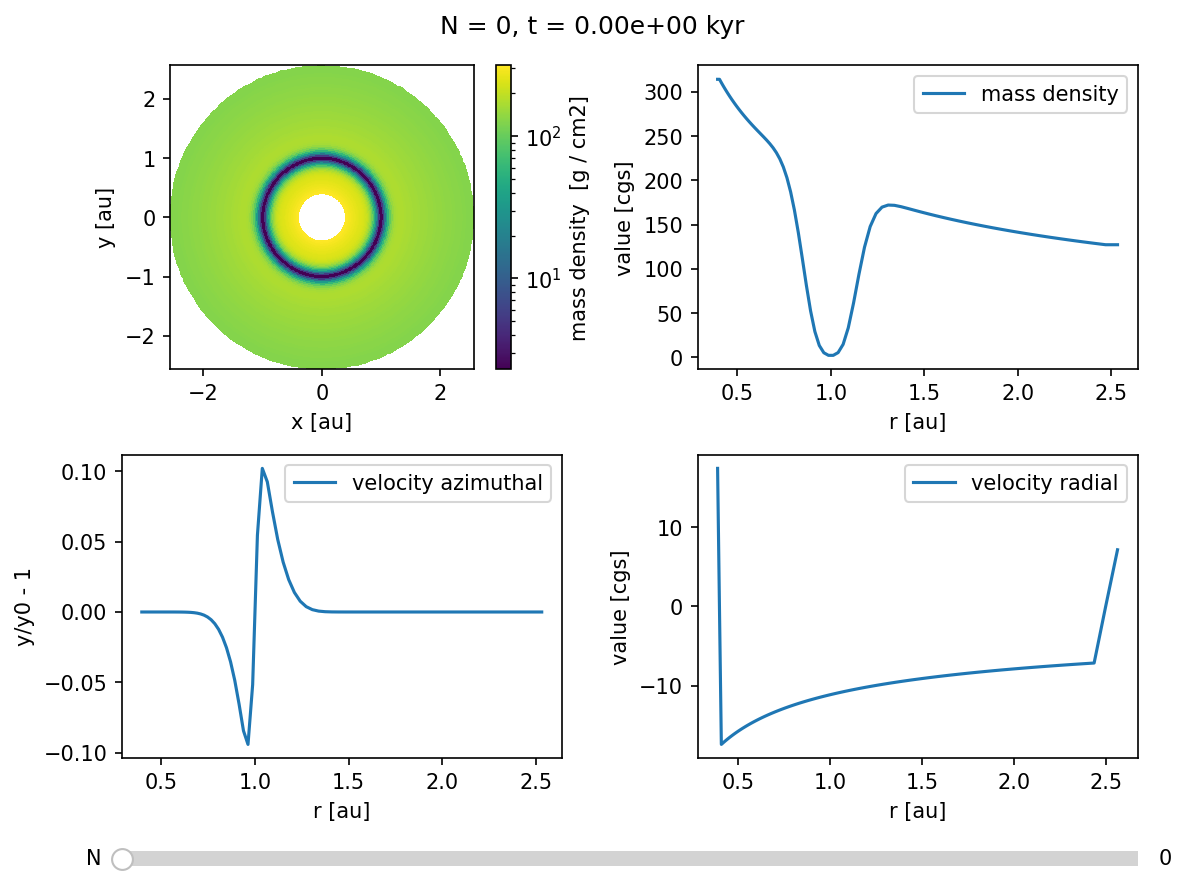

In [22]:
Overview("output/out",
        vars=["2:mass density",
                "1:mass density",
                "1:velocity azimuthal:rel",
                "1:velocity radial"]).create()

Now that the initial conditions have been adjusted, we can restart the simulation from snapshot number zero, which will pick up the modified conditions.

In [24]:
run(["auto", configfile], np=2, nt=1, exe="../../bin/fargocpt_exe", detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmpl62m17vg -x OMP_NUM_THREADS=1 ../../bin/fargocpt_exe auto setup.yml
fargo process pid 1390441

[0] MPI rank #  0 runs as process 1390445
[1] MPI rank #  1 runs as process 1390446
[0] MPI rank #  0 OpenMP thread #  0 of  1 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  0 of  1 on cpt-kamino
[0] fargo: This file was compiled on Nov 14 2023, 12:56:40.
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 5.00000e+00 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflecting
[0] BC: Vaz inner = keplerian
[0] BC: Vaz outer = keplerian
[0] DampingTimeFactor: 1.0

0

And finally, let's see how this system evolved.

Uncomment the first line to get an interactive widget, if your jupyter installation supports it.

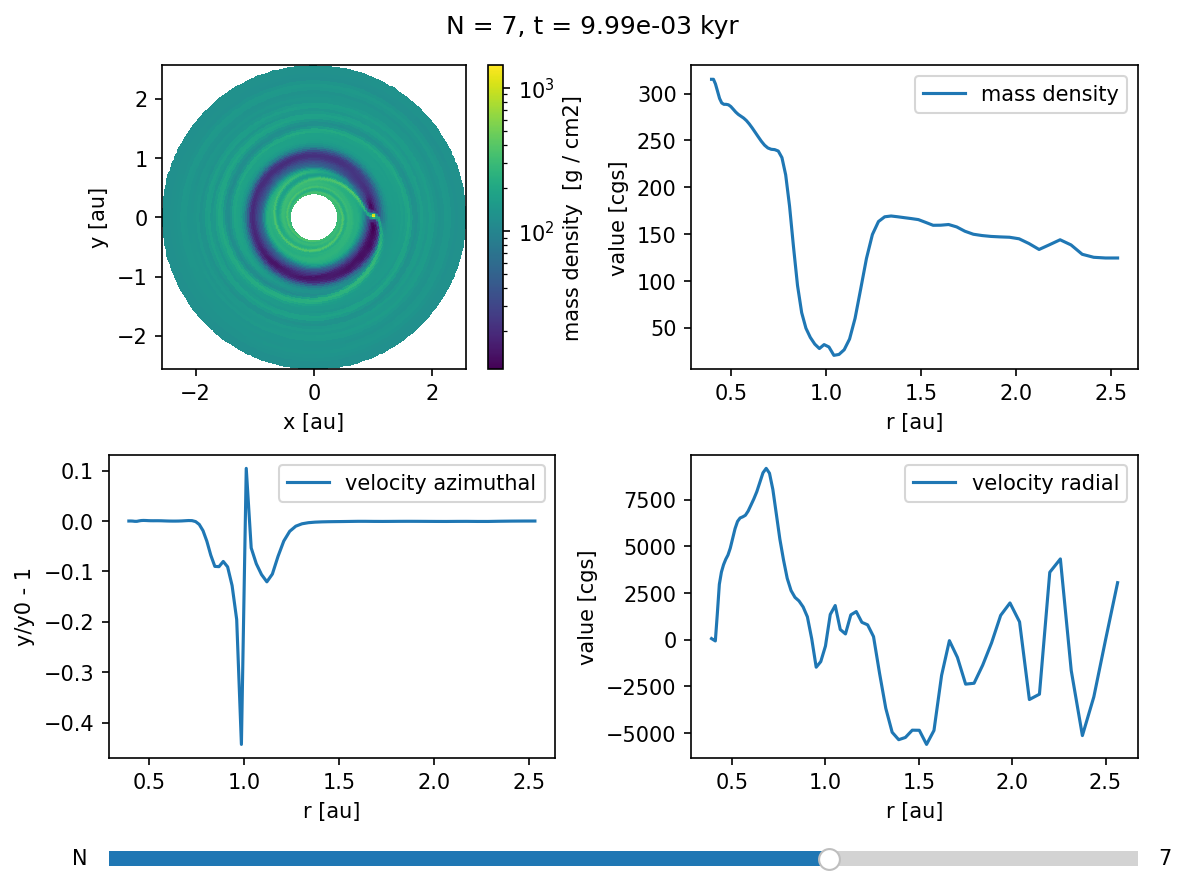

In [25]:
%matplotlib inline
Overview("output/out", start=7,
        vars=["2:mass density",
                "1:mass density",
                "1:velocity azimuthal:rel",
                "1:velocity radial"]).create();